In [ ]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor)
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split, RandomizedSearchCV
import optuna

In [2]:
# Загружаем данные
data = pd.read_csv('data/si_data.csv')

In [3]:
# Разделяем данные
X = data.drop(columns=['SI_log'])
y = data['SI_log']

In [ ]:
# Разделение данных (70% тренировочные, 30% тестовые)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Тренировочные данные: {X_train.shape[0]}")
print(f"Тестовые данные: {X_test.shape[0]}")

Тренировочные данные: 650
Тестовые данные: 279


In [5]:
# Инициализация моделей со стандартными параметрами
models = {
    'XGBoost': XGBRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(verbose=0, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'HistGradient Boosting': HistGradientBoostingRegressor(random_state=42),
    'Extra Trees': ExtraTreesRegressor(random_state=42),
}

In [6]:
# Функция для оценки моделей
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """Оценивает модель и возвращает метрики"""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return {
        'RMSE': round(np.sqrt(mean_squared_error(y_test, y_pred)), 4),
        'MAE': round(mean_absolute_error(y_test, y_pred), 4),
        'R2': round(r2_score(y_test, y_pred), 4)
    }

In [7]:
# Оценка базовых моделей (без подбора параметров)
base_results = []
for name, model in models.items():
    metrics = evaluate_model(model, X_train, y_train, X_test, y_test)
    base_results.append({
        'Model': name,
        **metrics,
        'Hyperparametres': False
    })
    
base_results = pd.DataFrame(base_results)
display(base_results.sort_values('RMSE', ascending=False))

,Model,RMSE,MAE,R2,Hyperparametres
5,Extra Trees,1.0971,0.8137,0.1007,False
0,XGBoost,1.0890,0.8023,0.1140,False
4,HistGradient Boosting,1.0737,0.8208,0.1387,False
2,CatBoost,1.0624,0.8012,0.1568,False
3,Gradient Boosting,1.0541,0.8203,0.1699,False
1,Random Forest,1.0247,0.7816,0.2155,False


Первоначально были протестированы шесть моделей без подбора гиперпараметров. Наилучший результат показала Random Forest, которая достигла минимального значения RMSE (1.0247) и наивысшего R2 (0.2155). Хуже всех с задачей справилась Extra Trees, продемонстрировав самое высокое значение RMSE (1.0971) и наименьший коэффициент детерминации (R2 = 0.1007).

In [ ]:
"""
Определяем словарь param_grid с диапазонами гиперпараметров для каждой модели.
- Числовые параметры задаются как кортеж (min, max) и:
  - преобразуются в списки при использовании RandomizedSearchCV,
  - или напрямую используются в Optuna для проб в указанных границах.
- Категориальные параметры задаются списками (например: ['sqrt', 'log2', None]).
Словарь используется для автоматического подбора параметров с помощью разных стратегий оптимизации.
"""

param_grid = {
    'XGBoost': {
        'n_estimators': (100, 500),
        'max_depth': (3, 11),
        'learning_rate': (0.01, 0.3),
        'subsample': (0.5, 1.0),
        'colsample_bytree': (0.5, 1.0),
        'gamma': (0.0, 5.0),
        'min_child_weight': (1, 10),
    },

    'Random Forest': {
        'n_estimators': (100, 300),
        'max_depth': (4, 20),
        'min_samples_split': (2, 18),
        'min_samples_leaf': (1, 18),
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True],
    },

    'CatBoost': {
        'iterations': (150, 1000),
        'depth': (4, 12),
        'learning_rate': (0.01, 0.3),
        'l2_leaf_reg': (1, 10),
        'border_count': [64, 128, 255],
        'bagging_temperature': (0.0, 1.0),
        'verbose': [False],
    },

    'Gradient Boosting': {
        'n_estimators': (100, 300),
        'learning_rate': (0.01, 0.3),
        'max_depth': (3, 10),
        'min_samples_split': (2, 18),
        'min_samples_leaf': (1, 18),
        'max_features': ['sqrt', 'log2', None],
        'subsample': (0.5, 1.0),
    },

    'HistGradient Boosting': {
        'max_iter': (100, 300),
        'learning_rate': (0.01, 0.3),
        'max_depth': (3, 11),
        'min_samples_leaf': (1, 25),
        'l2_regularization': (0.0, 1.0),
        'max_bins': [64, 128, 255],
    },

    'Extra Trees': {
        'n_estimators': (100, 300),
        'max_depth': (4, 20),
        'min_samples_split': (2, 18),
        'min_samples_leaf': (1, 18),
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True],
    }
}

In [ ]:
def convert_grid_for_random_search(grid, n_points=3):
    """
    Преобразует сетку гиперпараметров с диапазонами (кортежи) в списки значений для RandomizedSearchCV.
    - Если параметр задан диапазоном (tuple), генерирует n_points равномерно распределённых значений.
    - Если параметр уже список, оставляет без изменений.
    """
    rs_grid = {}
    for param, vals in grid.items():
        if isinstance(vals, tuple):
            # Генерируем значения в диапазоне
            if all(isinstance(v, int) for v in vals):
                rs_grid[param] = list(np.linspace(vals[0], vals[1], n_points, dtype=int))
            else:
                rs_grid[param] = list(np.linspace(vals[0], vals[1], n_points))
        elif isinstance(vals, list):
            rs_grid[param] = vals
        else:
            raise ValueError(f"Unknown param type for {param}: {vals}")
    return rs_grid


# Перебор моделей и подбор гиперпараметров с RandomizedSearchCV, используя преобразованную сетку параметров
tuned_results = []
for name in models.keys():
    # Преобразуем сетку из диапазонов в списки для RandomizedSearchCV
    rs_params = convert_grid_for_random_search(param_grid[name], n_points=3)

    search = RandomizedSearchCV(
        estimator=models[name],
        param_distributions=rs_params,
        n_iter=20,
        cv=3,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)

    metrics = evaluate_model(search.best_estimator_, X_train, y_train, X_test, y_test)
    tuned_results.append({
        'Model': name,
        **metrics,
        'Hyperparametres': True
    })

tuned_results = pd.DataFrame(tuned_results)
display(tuned_results.sort_values('RMSE', ascending=True))

,Model,RMSE,MAE,R2,Hyperparametres
3,Gradient Boosting,1.0222,0.8015,0.2194,True
2,CatBoost,1.0224,0.8146,0.2191,True
1,Random Forest,1.0243,0.8057,0.2162,True
0,XGBoost,1.0323,0.8141,0.2039,True
5,Extra Trees,1.0361,0.8235,0.1979,True
4,HistGradient Boosting,1.0457,0.8485,0.1831,True


После подбора гиперпараметров некоторые модели улучшили свои метрики. Особенно хорошо себя проявила модель Gradient Boosting, которая показала наименьшее значение RMSE (1.0222) и наивысшее значение R2 (0.2194), подтвердив свое преимущество после настройки.

In [11]:
# Объединение результатов
all_results = pd.concat([base_results, tuned_results])

# Вывод таблицы
display(all_results.sort_values('RMSE', ascending=True))

,Model,RMSE,MAE,R2,Hyperparametres
3,Gradient Boosting,1.0222,0.8015,0.2194,True
2,CatBoost,1.0224,0.8146,0.2191,True
1,Random Forest,1.0243,0.8057,0.2162,True
1,Random Forest,1.0247,0.7816,0.2155,False
0,XGBoost,1.0323,0.8141,0.2039,True
5,Extra Trees,1.0361,0.8235,0.1979,True
4,HistGradient Boosting,1.0457,0.8485,0.1831,True
3,Gradient Boosting,1.0541,0.8203,0.1699,False
2,CatBoost,1.0624,0.8012,0.1568,False
4,HistGradient Boosting,1.0737,0.8208,0.1387,False


Агрегированная таблица демонстрирует динамику изменения качества модели SI на каждом этапе — от начального состояния до финальной настройки с помощью Optuna. Несмотря на изначально низкие значения R2 у большинства моделей, последовательный подбор гиперпараметров позволил добиться заметного улучшения. Особенно хорошо себя зарекомендовал Gradient Boosting, улучшив как RMSE, так и R2 по сравнению с версией по умолчанию.

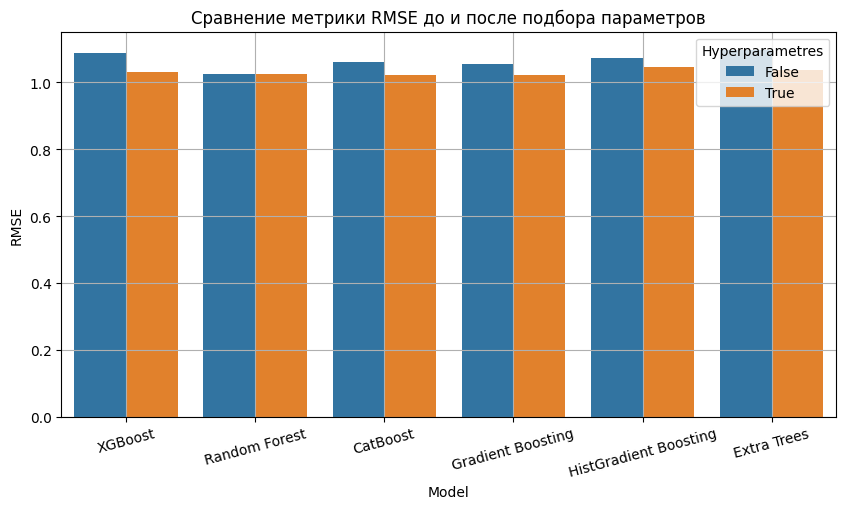

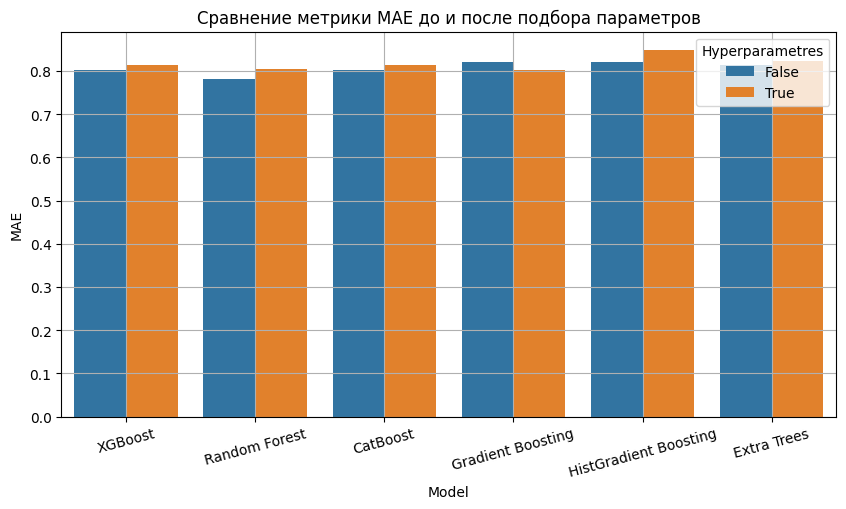

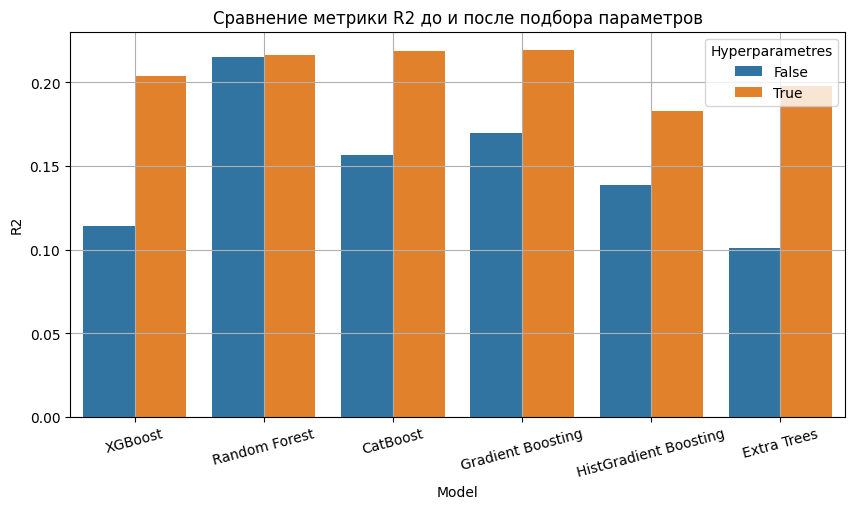

In [ ]:
# Визуализация сравнения моделей по метрикам (RMSE, MAE, R2) до и после подбора гиперпараметров
metrics_to_plot = ['RMSE', 'MAE', 'R2']

for metric in metrics_to_plot:
    plt.figure(figsize=(10, 5))
    sns.barplot(data=all_results, x='Model', y=metric, hue='Hyperparametres')
    plt.title(f'Сравнение метрики {metric} до и после подбора параметров')
    plt.ylabel(metric)
    plt.xticks(rotation=15)
    plt.grid(True)
    plt.show()

In [ ]:
# Анализ результатов: определение лучших и худших моделей по метрикам, выбор модели с минимальным RMSE и выявление моделей, у которых тюнинг не дал улучшений
tuned_only = all_results[all_results['Hyperparametres'] == True].copy()
baseline = all_results[all_results['Hyperparametres'] == False].copy()

# Модель, выбранная для дальнейшей оптимизации
chosen_model = all_results.sort_values('RMSE').iloc[0]['Model']

# Проход по метрикам
for metric in ['RMSE', 'MAE', 'R2']:
    print(f"\nМетрика: {metric}")

    ascending = metric != 'R2'  # для R2 наоборот: чем больше — тем лучше

    best_model = all_results.sort_values(metric, ascending=ascending).iloc[0]
    worst_model = all_results.sort_values(metric, ascending=not ascending).iloc[0]

    print(f"Лучшая модель: **{best_model['Model']}** → {metric} = {best_model[metric]:.4f}")
    print(f"Худшая модель: **{worst_model['Model']}** → {metric} = {worst_model[metric]:.4f}")


    # Сравнение тюнингованных с базовыми версиями
    merged = tuned_only.merge(
        baseline,
        on='Model',
        suffixes=('_tuned', '_base')
    ).drop_duplicates('Model')

    if metric == 'R2':
        stagnant = merged[merged[f'{metric}_tuned'] <= merged[f'{metric}_base']]['Model'].tolist()
    else:
        stagnant = merged[merged[f'{metric}_tuned'] >= merged[f'{metric}_base']]['Model'].tolist()

    if stagnant:
        print(f"Без улучшений или хуже: {', '.join(sorted(set(stagnant)))}")


Метрика: RMSE
Лучшая модель: **Gradient Boosting** → RMSE = 1.0222
Худшая модель: **Extra Trees** → RMSE = 1.0971

Метрика: MAE
Лучшая модель: **Random Forest** → MAE = 0.7816
Худшая модель: **HistGradient Boosting** → MAE = 0.8485
Без улучшений или хуже: CatBoost, Extra Trees, HistGradient Boosting, Random Forest, XGBoost

Метрика: R2
Лучшая модель: **Gradient Boosting** → R2 = 0.2194
Худшая модель: **Extra Trees** → R2 = 0.1007


In [ ]:
"""
Оптимизация гиперпараметров лучшей модели с помощью Optuna:

1. Определяем лучшую модель по метрике RMSE из предыдущих результатов.
2. Задаём пространство поиска гиперпараметров, учитывая типы.
3. Запускаем Optuna для минимизации RMSE с 5-fold кросс-валидацией.
4. Обучаем финальную модель на оптимальных параметрах.
5. Вычисляем и выводим метрики качества на тесте.
6. Сравниваем финальный результат с предыдущей лучшей версией модели.
"""

# Выбираем лучшую модель
best_model_name = all_results.sort_values('RMSE').iloc[0]['Model']
print(f"Лучшая модель: {best_model_name}")

model_class = models[best_model_name]
param_space = param_grid[best_model_name]

def objective(trial):
    params = {}
    for param, values in param_space.items():
        # Если диапазон (tuple), предполагаем [min, max]
        if isinstance(values, tuple) and len(values) == 2:
            low, high = values
            if isinstance(low, int) and isinstance(high, int):
                params[param] = trial.suggest_int(param, low, high)
            else:
                params[param] = trial.suggest_float(param, low, high)
        # Если список, то категориальный параметр
        elif isinstance(values, list):
            # Если это список с bool или str/None - категориальный
            if all(isinstance(v, bool) for v in values) or all(isinstance(v, (str,type(None))) for v in values):
                params[param] = trial.suggest_categorical(param, values)
            # Если числа — тоже категориальный (например дискретные значения)
            elif all(isinstance(v, (int,float)) for v in values):
                params[param] = trial.suggest_categorical(param, values)
            else:
                raise ValueError(f"Unsupported list param type for '{param}': {values}")
        else:
            raise ValueError(f"Unsupported param format for '{param}': {values}")

    params['random_state'] = 42

    model = model_class.__class__(**params)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    neg_rmse = cross_val_score(model, X_train, y_train,
                               scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1).mean()
    return -neg_rmse

print(f"\nЗапуск Optuna для {best_model_name}...")
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100, show_progress_bar=True)

print(f"\nЛучшие параметры:")
print(study.best_params)

final_model = model_class.__class__(**study.best_params, random_state=42)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
final_mae = mean_absolute_error(y_test, y_pred)
final_r2 = r2_score(y_test, y_pred)

print("\nФинальные метрики:")
print(f"RMSE: {final_rmse:.4f}")
print(f"MAE: {final_mae:.4f}")
print(f"R2: {final_r2:.4f}")

prev_versions = all_results[all_results['Model'] == best_model_name]
prev_best = prev_versions.sort_values('RMSE').iloc[0]

print("\nСравнение с предыдущей лучшей версией этой модели (до Optuna):")
print(f"RMSE было: {prev_best['RMSE']:.4f} → стало: {final_rmse:.4f}")
print(f"Улучшение: {prev_best['RMSE'] - final_rmse:.4f}")
print(f"R2 было: {prev_best['R2']:.4f} → стало: {final_r2:.4f}")
print(f"Улучшение: {prev_best['R2'] - final_r2:.4f}")

[I 2025-07-26 04:50:15,160] A new study created in memory with name: no-name-4ce5d0bc-fb41-49e7-97c0-f078ccfc9f1d


Лучшая модель: Gradient Boosting

Запуск Optuna для Gradient Boosting...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-26 04:50:19,123] Trial 0 finished with value: 1.1734655176406936 and parameters: {'n_estimators': 175, 'learning_rate': 0.28570714885887566, 'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': None, 'subsample': 0.8005575058716043}. Best is trial 0 with value: 1.1734655176406936.
[I 2025-07-26 04:50:23,599] Trial 1 finished with value: 1.0708436595007058 and parameters: {'n_estimators': 242, 'learning_rate': 0.01596950334578271, 'max_depth': 10, 'min_samples_split': 16, 'min_samples_leaf': 4, 'max_features': None, 'subsample': 0.762378215816119}. Best is trial 1 with value: 1.0708436595007058.
[I 2025-07-26 04:50:26,081] Trial 2 finished with value: 1.124358456605623 and parameters: {'n_estimators': 186, 'learning_rate': 0.09445645065743215, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': None, 'subsample': 0.5998368910791798}. Best is trial 1 with value: 1.0708436595007058.
[I 2025-07-26 04:50:27,562] Trial 3 finish

Финальная гиперпараметрическая оптимизация с использованием Optuna позволила добиться незначительного, но стабильного улучшения метрик. Значение RMSE снизилось до 1.0174, а R2 выросло до 0.2267, что закрепило преимущество модели Gradient Boosting.

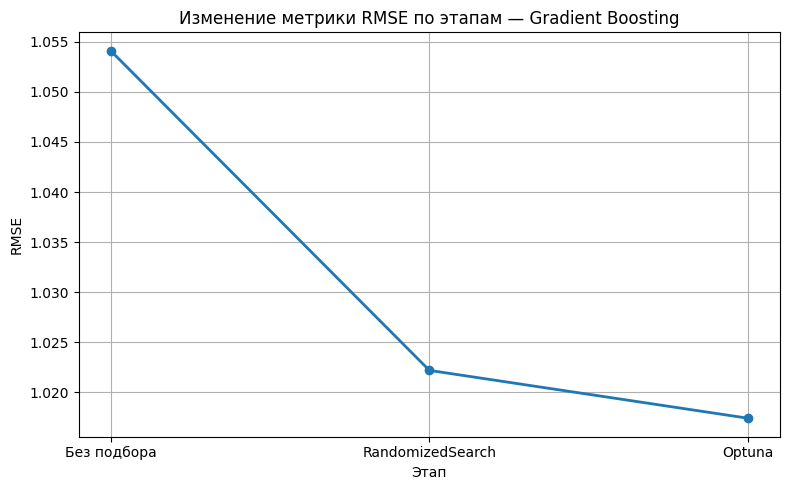

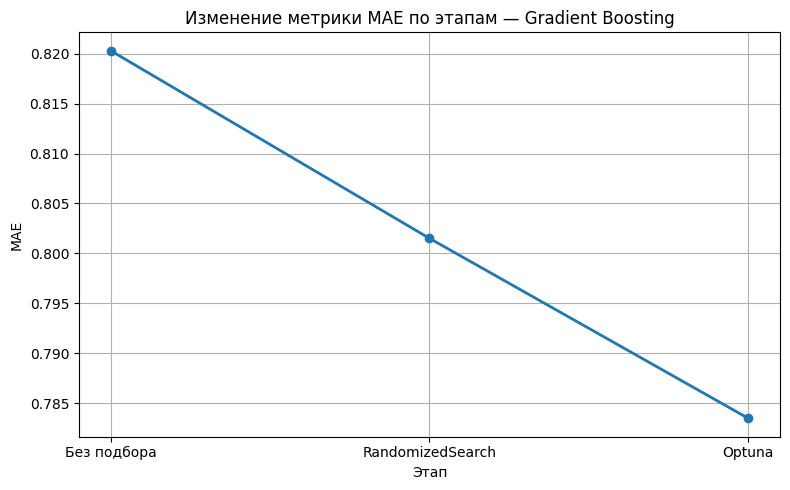

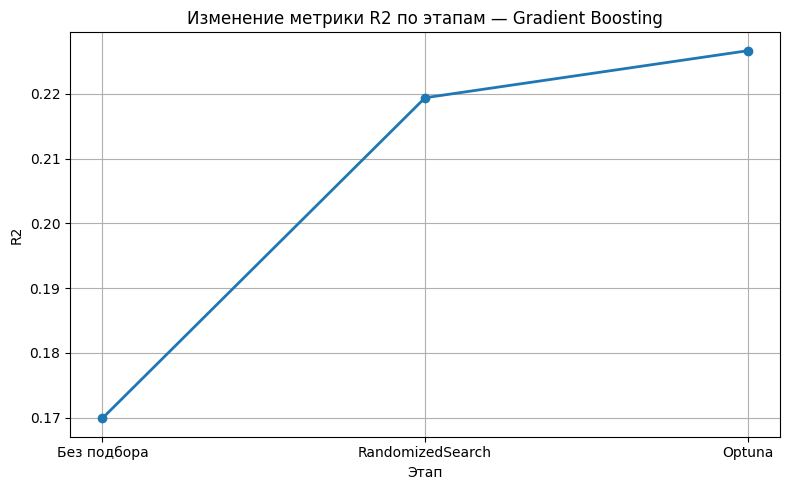

In [ ]:
target_model = best_model_name

# 1. Получаем без подбора
base_row = all_results[(all_results['Model'] == target_model) & (all_results['Hyperparametres'] == False)].sort_values('RMSE').iloc[0]

# 2. С подбором (RandomizedSearch)
random_row = all_results[(all_results['Model'] == target_model) & (all_results['Hyperparametres'] == True)].sort_values('RMSE').iloc[0]

# 3. Финальные метрики Optuna (берём из переменных после обучения)
optuna_metrics = {
    'RMSE': final_rmse,
    'MAE': final_mae,
    'R2': final_r2
}

# 4. Собираем всё в DataFrame
progress = pd.DataFrame({
    'Этап': ['Без подбора', 'RandomizedSearch', 'Optuna'],
    'RMSE': [base_row['RMSE'], random_row['RMSE'], optuna_metrics['RMSE']],
    'MAE':  [base_row['MAE'],  random_row['MAE'],  optuna_metrics['MAE']],
    'R2':   [base_row['R2'],   random_row['R2'],   optuna_metrics['R2']],
})

# 5. Строим график
for metric in ['RMSE', 'MAE', 'R2']:
    plt.figure(figsize=(8, 5))
    plt.plot(progress['Этап'], progress[metric], marker='o', linewidth=2)
    plt.title(f'Изменение метрики {metric} по этапам — {target_model}')
    plt.xlabel('Этап')
    plt.ylabel(metric)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Модель Gradient Boosting оказалась наилучшей для задачи предсказания SI после всех этапов настройки. Несмотря на сравнительно низкий R2, улучшение модели по всем ключевым метрикам делает её предпочтительным вариантом для данной задачи.